### 1. Laboratorio clase 8: Introducción y contexto

En este laboratorio abordaremos de forma práctica los fundamentos del aprendizaje por refuerzo, así como su aplicación en el contexto moderno de modelos de lenguaje ajustados mediante retroalimentación humana (RLHF). Los objetivos de este laboratorio son:

- Comprender el concepto de aprendizaje por refuerzo (RL) y su diferencia con el aprendizaje supervisado.
- Implementar un entorno tipo bandido multibrazo (multi-armed bandit) como ejemplo clásico de RL.
- Simular un ciclo de retroalimentación humana donde se refuerza un modelo de lenguaje en base a preferencias.
- Comparar el desempeño del modelo antes y después de la retroalimentación.
- Aplicar la técnica de fine-tuning ligero como proxy pedagógico de RLHF.

Este laboratorio combina experimentos interactivos, visualizaciones y ajustes sobre modelos reales de Hugging Face para ilustrar cómo se entrena un modelo a partir de la retroalimentación.


### 2. Aprendizaje por refuerzo clásico

En esta sección, implementamos un entorno clásico de aprendizaje por refuerzo conocido como el problema del **bandido multibrazo**. Este entorno representa un agente que debe elegir entre varias opciones (máquinas tragamonedas), cada una con una probabilidad diferente de generar una recompensa.

El objetivo del agente es maximizar su recompensa acumulada balanceando:
- **Exploración**: probar acciones menos conocidas.
- **Explotación**: elegir acciones que han demostrado buenos resultados.

Usamos una estrategia epsilon-greedy para modelar este comportamiento y visualizamos la evolución de las recompensas estimadas y acumuladas a lo largo del tiempo.

In [1]:
# Importamos librerías necesarias

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Definimos números de acciones y medias verdaderas. Además inicializamos contadores y recompensas.

true_means = [0.2, 0.5, 0.75]  
num_actions = len(true_means)
counts = [0] * num_actions  
rewards = [0] * num_actions  
n_rounds = 200
total_rewards = []
estimated_means = [0.0] * num_actions

In [3]:
# Calculamos recompensas y medias estimadas para cada acción.

for t in range(n_rounds):
    epsilon = 0.1
    if np.random.rand() < epsilon:
        action = np.random.randint(num_actions)  # exploración
    else:
        action = np.argmax(estimated_means)  # explotación
        
    reward = 1 if np.random.rand() < true_means[action] else 0
    counts[action] += 1
    rewards[action] += reward
    estimated_means[action] = rewards[action] / counts[action]
    total_rewards.append(reward)

print("Promedios estimados por máquina:", estimated_means)
print("Recompensa total acumulada:", sum(total_rewards))


Promedios estimados por máquina: [0.34782608695652173, 0.48623853211009177, 0.7794117647058824]
Recompensa total acumulada: 114


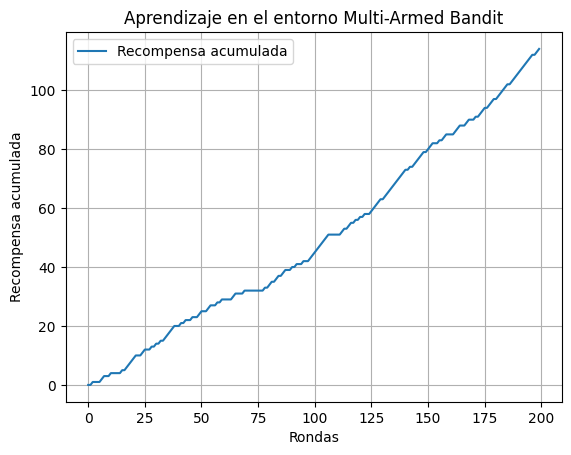

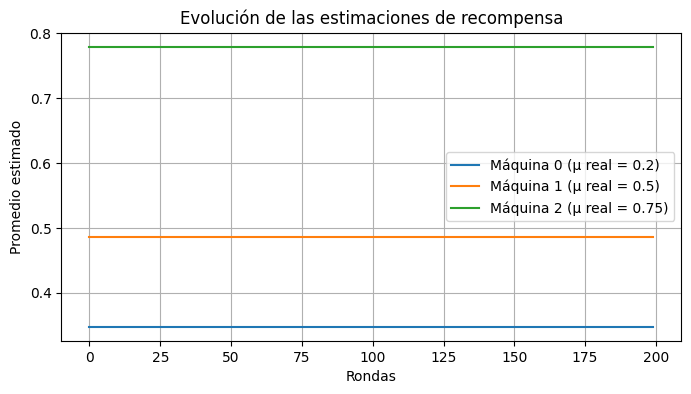

In [4]:
# Visualizamos los resultados

plt.plot(np.cumsum(total_rewards), label="Recompensa acumulada")
plt.xlabel("Rondas")
plt.ylabel("Recompensa acumulada")
plt.title("Aprendizaje en el entorno Multi-Armed Bandit")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
for i in range(num_actions):
    pulls = [1 if a == i else 0 for a in np.argmax(np.random.rand(n_rounds, num_actions), axis=1)]
    plt.plot([rewards[i] / counts[i] if counts[i] > 0 else 0 for _ in range(n_rounds)], label=f"Máquina {i} (μ real = {true_means[i]})")
plt.xlabel("Rondas")
plt.ylabel("Promedio estimado")
plt.title("Evolución de las estimaciones de recompensa")
plt.legend()
plt.grid(True)
plt.show()

Este gráfico muestra cómo las estimaciones de recompensa para cada máquina tragamonedas cambian a medida que el agente gana experiencia.

Idealmente, la línea correspondiente a la máquina con mayor probabilidad de recompensa (μ = 0.75) debería estabilizarse como la más alta, lo que indicaría que el agente ha aprendido a preferirla con el tiempo.

### 3. Aprendizaje por refuerzo con retroalimentación humana

En esta sección pasamos de un entorno artificial y controlado a una aplicación más realista y moderna: el entrenamiento de un modelo de lenguaje mediante retroalimentación humana.

Simulamos el proceso de RLHF (Reinforcement Learning from Human Feedback) de la siguiente manera:
- El modelo genera múltiples salidas (resúmenes) para un mismo texto de entrada.
- El usuario actúa como fuente de retroalimentación humana seleccionando la mejor opción.
- El modelo es ajustado con base en esa preferencia mediante una actualización supervisada.
- Se compara la salida del modelo antes y después del ajuste para evaluar la influencia del refuerzo.

Este ejercicio ofrece una visión práctica del fine-tuning ligero como una aproximación pedagógica a los procesos de alineación que utilizan modelos de lenguaje modernos.

In [5]:
# Iportamos librerías necesarias

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy

In [6]:
# Importamos modelo preentrenado y tokenizador. Guardamos el modelo original para comparaciones posteriores.

model_id = "mrm8488/bert2bert_shared-spanish-finetuned-summarization"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
original_model = deepcopy(model)
original_model.eval()


/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0521 18:13:03.399000 14346 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, us

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
# Escribimos el texto a resumir. Además definimos el prompt que vamos a usar para darle al modelo.

text = """
La robótica y la inteligencia artificial están cada vez más presentes en la vida cotidiana.
Desde asistentes virtuales hasta vehículos autónomos, estas tecnologías están revolucionando
la manera en que interactuamos con el mundo y plantean nuevos desafíos sociales y éticos.
"""

input_prompt = "resumir: " + text

In [8]:
# Definimos clases y functiones útiles para entrenar el modelo por refuerzo. También definimos optimizador y función de pérdida 

class SummaryDataset(Dataset):
    """
    Dataset personalizado para entrenamiento supervisado de resúmenes.

    Args:
        prompt (str): Texto de entrada (prompt) para el modelo.
        summary (str): Resumen seleccionado como objetivo.
    """
    def __init__(self, prompt, summary):
        """
        Inicializa el dataset con el prompt y el resumen objetivo.

        Args:
            prompt (str): Texto de entrada.
            summary (str): Resumen objetivo.
        """
        self.prompt = prompt
        self.summary = summary

    def __len__(self):
        """
        Devuelve el número de ejemplos en el dataset.

        Returns:
            int: Número de ejemplos (siempre 1 en este caso).
        """
        return 1

    def __getitem__(self, idx):
        """
        Devuelve el par (input_ids, target_ids) tokenizados para el modelo.

        Args:
            idx (int): Índice del ejemplo (no relevante aquí).

        Returns:
            tuple: input_ids y target_ids como tensores.
        """
        x = tokenizer(self.prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
        y = tokenizer(self.summary, return_tensors="pt", padding=True, truncation=True, max_length=64)
        return x["input_ids"].squeeze(0), y["input_ids"].squeeze(0)

def get_valid_index(max_index):
    """
    Solicita al usuario que seleccione un índice válido para elegir el mejor resumen.

    Args:
        max_index (int): Índice máximo permitido.

    Returns:
        int: Índice seleccionado por el usuario.
    """
    while True:
        try:
            user_input = input(f"Selecciona el índice del mejor resumen (0–{max_index}): ")
            selection = int(user_input)
            if 0 <= selection <= max_index:
                return selection
            else:
                print("Por favor ingresa un número válido.")
        except ValueError:
            print("Entrada no válida. Intenta con un número entero.")

optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
# Generamos una sola ronda de refuerzo y pedimos al usuario que seleccione el mejor resumen
print("\n--- Ronda de refuerzo ---")

input_tokens = tokenizer(input_prompt, return_tensors="pt", max_length=512, truncation=True)
summaries = []

for _ in range(3):
    output = model.generate(
        input_ids=input_tokens["input_ids"],
        attention_mask=input_tokens["attention_mask"],
        max_new_tokens=50,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1.0,
        pad_token_id=tokenizer.eos_token_id or tokenizer.pad_token_id
    )
    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    summaries.append(summary)

print("\nResúmenes generados:\n")
for i, summary in enumerate(summaries):
    print(f"[{i}] {summary}\n")

selected_index = get_valid_index(len(summaries) - 1)
selected_summary = summaries[selected_index]

train_data = SummaryDataset(input_prompt, selected_summary)
train_loader = DataLoader(train_data, batch_size=1)

for input_ids, target_ids in train_loader:
    output = model(input_ids=input_ids, labels=target_ids)
    loss = output.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(f"\n Modelo actualizado con el resumen seleccionado: [{selected_index}]")



--- Ronda de refuerzo ---

Resúmenes generados:

[0] La tecnología está revolucionando la manera en que interactuamos con el mundo y plantean nuevos desafíos sociales y éticos

[1] La robótica y la inteligencia artificial están cada vez más presentes en la vida cotidiana. Esta tecnología está revolucionando la manera en que interactuamos con el mundo y plantean nuevos desafíos sociales y éticos

[2] Las tecnologías revolucionan la manera en que interactuamos con el mundo y plantean nuevos desafíos sociales y éticos



/Users/fdiazja/nlp_env/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:616: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/Users/fdiazja/nlp_env/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:636: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



 Modelo actualizado con el resumen seleccionado: [2]


In [10]:
# Texto nuevo para comparar resúmenes

new_text = """
El aprendizaje automático está cambiando la forma en que las empresas toman decisiones.
Desde la detección de fraudes hasta la recomendación de productos, los algoritmos permiten analizar grandes volúmenes de datos
y ofrecer soluciones más eficientes, aunque también plantean preguntas sobre privacidad y transparencia.
"""
eval_prompt = "resumir: " + new_text
eval_tokens = tokenizer(eval_prompt, return_tensors="pt", max_length=512, truncation=True)

with torch.no_grad():
    output_original = original_model.generate(
        **eval_tokens,
        max_new_tokens=50,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1.0,
        pad_token_id=tokenizer.eos_token_id or tokenizer.pad_token_id
    )
original_summary = tokenizer.decode(output_original[0], skip_special_tokens=True)

with torch.no_grad():
    output_updated = model.generate(
        **eval_tokens,
        max_new_tokens=50,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1.0,
        pad_token_id=tokenizer.eos_token_id or tokenizer.pad_token_id
    )
updated_summary = tokenizer.decode(output_updated[0], skip_special_tokens=True)

print("\n Texto original:\n", new_text.strip())
print("\n Resumen original (antes del refuerzo):\n", original_summary)
print("\n Resumen reforzado (después del refuerzo):\n", updated_summary)



 Texto original:
 El aprendizaje automático está cambiando la forma en que las empresas toman decisiones.
Desde la detección de fraudes hasta la recomendación de productos, los algoritmos permiten analizar grandes volúmenes de datos
y ofrecer soluciones más eficientes, aunque también plantean preguntas sobre privacidad y transparencia.

 Resumen original (antes del refuerzo):
 El aprendizaje automático está cambiando la forma en que las empresas toman decisiones. Y el aprendizaje automático, cambio de forma, sirve para analizar grandes volúmenes de datos y ofrecer respuestas

 Resumen reforzado (después del refuerzo):
 El aprendizaje automático está cambiando la forma en que las empresas toman decisiones. Desde la detección de fraudes hasta la recomendación de productos, los algoritmos permiten analizar grandes volúmenes de datos
